In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import AutoModel
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tqdm import tqdm
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# 1. Load models trained with DPO and SimPO

In [26]:
mistral_7b_DPO_tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/Mistral-7B-Instruct-DPO", trust_remote_code=True, cache_dir="../../models/Mistral-7B-Instruct-DPO")
mistral_7b_DPO = AutoModelForCausalLM.from_pretrained("princeton-nlp/Mistral-7B-Instruct-DPO", trust_remote_code=True, attn_implementation="flash_attention_2", cache_dir="../../models/Mistral-7B-Instruct-DPO", torch_dtype=torch.bfloat16).to(device)
mistral_7b_DPO.eval()

ImportError: FlashAttention2 has been toggled on, but it cannot be used due to the following error: the package flash_attn seems to be not installed. Please refer to the documentation of https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2 to install Flash Attention 2.

# 2. Experiments
## 2.1 Relation between Log probability and |y|

In [22]:
prompt_text = ["Once upon a time, in a land far, far away,", "fairies danced under the moonlight, casting shimmering shadows on the ground."]
prompt_inputs = mistral_7b_DPO_tokenizer(prompt_text, return_tensors="pt", padding=True).to(device)
print(f"Prompt text: {prompt_inputs}")
prompt_length = prompt_inputs.input_ids.shape[1]
print(f"Prompt length: {prompt_length}")

Prompt text: {'input_ids': tensor([[    2,     2,     2,     2,     2,     1,  5713,  3714,   264,   727,
         28725,   297,   264,  2533,  2082, 28725,  2082,  1753, 28725],
        [    1,  4968,   497,   281,  3692,   916,   272, 11375,  3646, 28725,
         24668,   480, 14917,   288, 17207,   356,   272,  3414, 28723]],
       device='cuda:0'), 'attention_mask': tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}
Prompt length: 19


Generating responses...


100%|██████████| 200/200 [09:45<00:00,  2.93s/it]


Plotting the results...


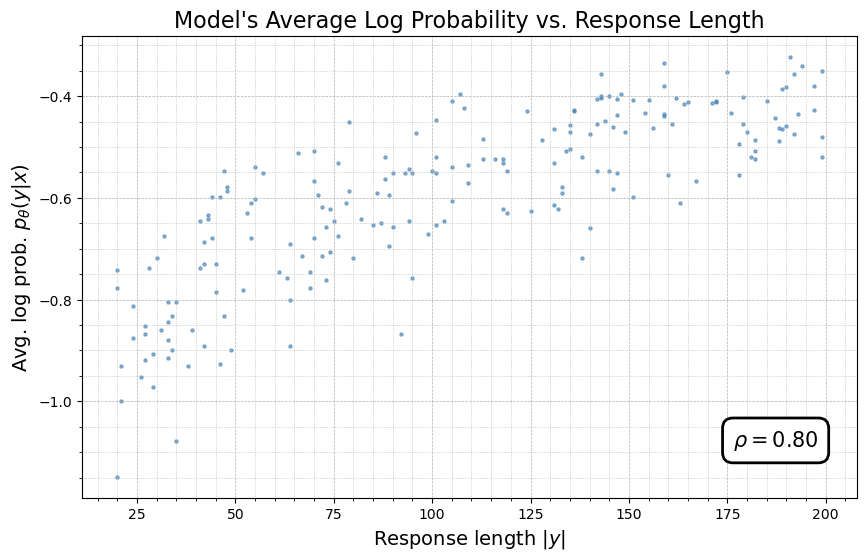

In [25]:
num_generations = 200 
response_lengths = []
avg_log_probs = []
print("Generating responses...")

with torch.no_grad(): 
    for _ in tqdm(range(num_generations)):
        max_len = np.random.randint(20, 200)
        generated_ids = mistral_7b_DPO.generate(
            **prompt_inputs,
            max_new_tokens=max_len,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
            pad_token_id=mistral_7b_DPO_tokenizer.eos_token_id # 明确指定pad_token_id以避免警告
        )

        response_ids = generated_ids[:, prompt_length:]
        response_length = response_ids.shape[1]
        
        if response_length == 0:
            continue

        # --- 关键步骤：计算平均对数概率 ---
        # 将prompt和response拼接，作为模型的输入
        full_ids = torch.cat([prompt_inputs.input_ids, response_ids], dim=1)
        
        # 获取模型对于整个序列的logits
        outputs = mistral_7b_DPO(full_ids, labels=full_ids)
        logits = outputs.logits

        # 我们只关心对response部分的预测，所以选择相应的logits
        # logits_for_response 的形状是 [batch_size, response_length, vocab_size]
        logits_for_response = logits[:, prompt_length-1:-1, :]
        
        # 使用log_softmax将logits转换为对数概率
        log_probs = torch.nn.functional.log_softmax(logits_for_response, dim=-1)

        # 从log_probs中收集到我们实际生成的token的对数概率
        # response_ids需要reshape以用于gather
        true_token_log_probs = torch.gather(log_probs, 2, response_ids.unsqueeze(-1)).squeeze(-1)
        
        # 计算平均对数概率
        avg_log_prob = true_token_log_probs.mean().item()

        # 存储结果
        response_lengths.append(response_length)
        avg_log_probs.append(avg_log_prob)

# --- 4. 可视化和分析 ---
print("Plotting the results...")

# 计算皮尔逊相关系数 (ρ)
correlation, _ = pearsonr(response_lengths, avg_log_probs)
rho_text = f"$\\rho = {correlation:.2f}$"

# 创建散点图
plt.figure(figsize=(10, 6))
plt.scatter(response_lengths, avg_log_probs, s=5, alpha=0.6, c='steelblue')

# 图表美化
plt.title("Model's Average Log Probability vs. Response Length", fontsize=16)
plt.xlabel("Response length $|y|$", fontsize=14)
plt.ylabel("Avg. log prob. $p_{\\theta}(y|x)$", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.5)

# 在图上添加相关系数的文本框
plt.text(0.95, 0.15, rho_text, transform=plt.gca().transAxes,
         fontsize=15, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=2))

plt.show()